# Overcoming Overfitting: Building a Robust CNN


* **Enhance the Data Pipeline** with more powerful data augmentation to create a richer training set.

* **Refactor the Architecture for Modularity**, creating reusable `CNNBlocks` for cleaner, more scalable code.

* **Integrate Advanced Layers** like **Batch Normalization** to stabilize training and improve generalization.

* **Deploy a Robust Regularization Strategy** using **Dropout** and **Weight Decay** to combat overfitting directly.



<a name='0'></a>

## Imports

In [1]:
import copy 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
import helper_utils
import unittests

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1 - Upgrading Your Data Pipeline


A fundamental strategy for building more robust models is **data augmentation**. By creating modified versions of the training images, flipping them, rotating them, I will teach my model to recognize subjects in a variety of conditions. This technique is a pivotal first line of defense against overfitting. The first task is to build an even more powerful set of image transformations to supercharge my dataset.

<a name='1-1'></a>
### 1.1 - Defining More Powerful Transformations

Let's begin by setting up the essential components for the data pipeline. I will start by defining the standard normalization values for the CIFAR-100 dataset and then create the transformation pipelines themselves.

* Define the `cifar100_mean` and `cifar100_std`, the mean and standard deviation values for the **CIFAR-100** dataset.

In [8]:
# Pre-calculated mean for each of the 3 channels of the CIFAR-100 dataset
cifar100_mean = (0.5071, 0.4867, 0.4408)
# Pre-calculated standard deviation for each of the 3 channels of the CIFAR-100 dataset
cifar100_std = (0.2675, 0.2565, 0.2761)

 The training transformation pipeline is where I apply data augmentation. To make the model even more robust, I will add a new technique to my arsenal this time: `RandomVerticalFlip`. While horizontal flipping is common, adding vertical flips can also help the model learn that an object's orientation might not always be upright, a useful feature for classifying things like insects or flowers from various angles.



In [ ]:


def define_transformations(mean, std):
    """
    Creates image transformation pipelines for training and validation.

    Args:
        mean (list or tuple): A sequence of mean values for each channel.
        std (list or tuple): A sequence of standard deviation values for each channel.

    Returns:
        train_transformations (torchvision.transforms.Compose): The training
                                                                transformation pipeline.
        val_transformations (torchvision.transforms.Compose): The validation
                                                                transformation pipeline.
    """
    
    # Define the sequence of transformations for the training dataset.
    train_transformations = transforms.Compose([
        # Randomly flip the image horizontally with a 50% probability.
        transforms.RandomHorizontalFlip(),
        # Randomly flip the image vertically with a 50% probability.
        transforms.RandomVerticalFlip(),
        # Rotate the image by a random angle between -15 and +15 degrees.
        transforms.RandomRotation(15),
        # Convert the image from a PIL Image or NumPy array to a PyTorch tensor.
        transforms.ToTensor(),
        # Normalize the tensor image with the given mean and standard deviation.
        transforms.Normalize(mean, std)
    ]) 
    
    # Define the sequence of transformations for the validation dataset.
    val_transformations = transforms.Compose([
        # Convert the image from a PIL Image or NumPy array to a PyTorch tensor.
        transforms.ToTensor(),
        # Normalize the tensor image with the given mean and standard deviation.
        transforms.Normalize(mean, std)
    ]) 
    
    # Return both transformation pipelines.
    return train_transformations, val_transformations

In [10]:
# Verify the Transformations
print("--- Verifying define_transformations ---\n")
train_transform_verify, val_transform_verify = define_transformations(cifar100_mean, cifar100_std)


print("Training Transformations:")
print(train_transform_verify)
print("-" * 30)
print("\nValidation Transformations:")
print(val_transform_verify)

--- Verifying define_transformations ---

Training Transformations:
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)
------------------------------

Validation Transformations:
Compose(
    ToTensor()
    Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
)


* Call the `define_transformations` function, passing the `cifar100_mean` and `cifar100_std` as arguments.
* This returns two separate transformation pipelines, which are stored in the `train_transform` and `val_transform` variables for later use.

In [12]:
# Create and store the training and validation transformation pipelines
train_transform, val_transform = define_transformations(cifar100_mean, cifar100_std)

<a name='1-2'></a>
### 1.2 - Assembling the Data Loaders

With the powerful new transformation pipelines defined, it is time to prepare the data for training. I will first specify the 15 target classes and then use the transformations to load the images and wrap them in `DataLoader` objects, which will feed the data to my model in batches.

* First, define the `all_target_classes` list.
* These are the same classes of flowers, mammals, and insects you worked with in the previous lab, ensuring you are tackling the same classification problem, but with an upgraded pipeline.

In [13]:
# Define the full class list.
all_target_classes = [
    # Flowers
    'orchid', 'poppy', 'rose', 'sunflower', 'tulip',
    # Mammals
    'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
    # Insects
    'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'
]

* Next, call the `load_cifar100_subset` function, passing in the class list (`all_target_classes`) and both transformation pipelines (`train_transform` and `val_transform`).
* This function handles the entire loading process and returns two PyTorch `Dataset` objects, which are stored in the `train_dataset` and `val_dataset` variables.

In [14]:
# Load the full datasets.
train_dataset, val_dataset = helper_utils.load_cifar100_subset(all_target_classes, train_transform, val_transform)

Dataset found in './cifar_100'. Loading from local files.
Dataset loaded successfully.

Filtering for 15 classes...
Filtering complete. Returning training and validation datasets.


<br>

With the datasets prepared, the final step is to wrap them in PyTorch's `DataLoader`. This utility is essential for feeding data to your model in manageable batches.

* Create the `train_loader` for the training data.
* Create the `val_loader` for the validation data.

In [15]:
# Set the number of samples to be processed in each batch
batch_size = 64

# Create a data loader for the training set, with shuffling enabled
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Create a data loader for the validation set, without shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

<a name='1-3'></a>
### 1.3 - Visualizing the Training Images

It is always a good practice to visualize the data. The following line calls a helper function to display a grid of random images from the `train_loader`.

 Since these images come from the training set, I should see the effects of my data augmentation pipeline in action. Look for images that have been randomly flipped horizontally, vertically, or rotated. This is an excellent way to confirm the transformations are working as expected.

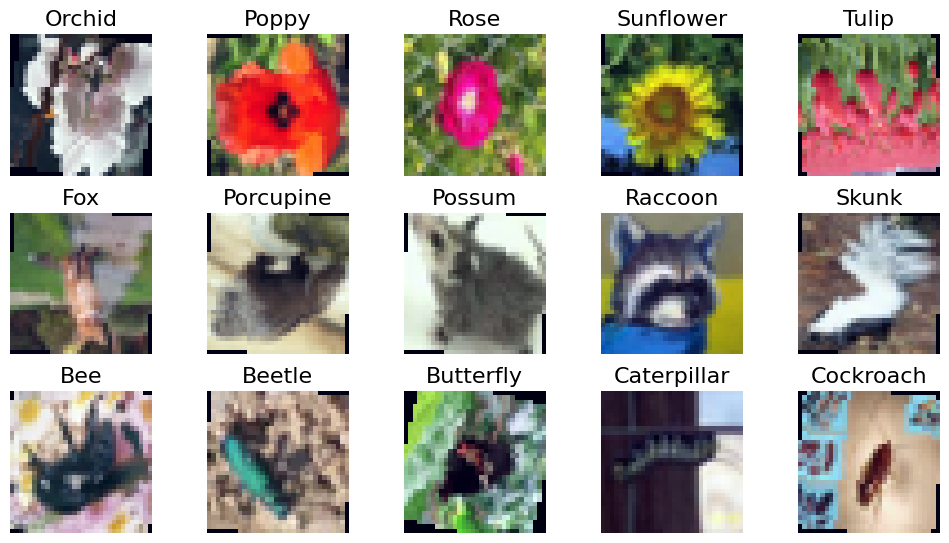

In [16]:
# Visualize a grid of random training images
helper_utils.visualise_images(train_loader, grid=(3, 5))

<a name='2'></a>
## 2 - Building a Modular and Robust CNN

With a more robust data pipeline in place, the next step is to enhance the model's architecture itself. This will refactor the original CNN to be more modular, efficient, and powerful. This is the next pivotal step toward resolving the overfitting problem and pushing the model's performance to new heights.

<a name='2-1'></a>
### 2.1 - The Power of Modularity: The CNNBlock

 A much better approach is to group these patterns into a single, reusable module. the first task is to create a `CNNBlock` that packages these layers together. This modular design makes the main model's code significantly cleaner and easier to manage.

<a name='2-1-1'></a>
#### 2.1.1 - <code>[BatchNorm2d Layer](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)</code>

As part of this new, improved block, I will also introduce a powerful new layer: `BatchNorm2d`. This layer is a pivotal technique for building modern, high performing deep neural networks.

 Batch Normalization as a traffic controller for the data flowing between the network's layers. After a convolutional layer processes a batch of images, the outputs (or activations) can have widely varying distributions from one batch to the next. `BatchNorm2d` steps in and normalizes these activations within each mini batch, adjusting them to have a consistent mean and standard deviation. It then uses two learnable parameters to scale and shift this normalized output, allowing the network itself to learn the optimal distribution for the data at that point.

This seemingly simple step provides three profound benefits:

* **It Stabilizes and Accelerates Training**: By keeping the distribution of data consistent between layers, it prevents later layers from having to constantly adapt to a shifting input from the layers before them. This stability allows to use higher learning rates, which can dramatically speed up how quickly the model learns.

* **It Acts as a Regularizer**: Because the normalization statistics are calculated for each unique mini batch, it introduces a slight amount of noise into the training process. This noise makes it harder for the model to perfectly memorize the training data, encouraging it to learn more general features and thus reducing overfitting.

* **It Reduces Sensitivity to Initialization**: The layer makes the model less dependent on the specific random weights it starts with, leading to more reliable and repeatable training results.

By adding `BatchNorm2d` to the `CNNBlock`, I am not just adding another layer; I am fundamentally making the model's training process more stable, efficient, and robust.



In [ ]:

class CNNBlock(nn.Module):
    """
    Defines a single convolutional block for a CNN.

    This block consists of a convolutional layer, batch normalization,
    a ReLU activation, and a max-pooling layer, bundled as a sequential module.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        """
        Initializes the layers of the CNNBlock.

        Args:
            in_channels (int): Number of channels in the input image.
            out_channels (int): Number of channels produced by the convolution.
            kernel_size (int, optional): Size of the convolving kernel. Defaults to 3.
            padding (int, optional): Zero-padding added to both sides of the input. Defaults to 1.
        """
        # Initialize the parent nn.Module class.
        super(CNNBlock, self).__init__()
         
        # Define the sequential container for the block's layers.
        self.block = nn.Sequential(
            # 2D convolutional layer
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            # Batch normalization
            nn.BatchNorm2d(out_channels),
            # ReLU activation
            nn.ReLU(),
            # Max pooling (2x2)
            nn.MaxPool2d(kernel_size=2)
        )


    def forward(self, x):
        """
        Defines the forward pass for the CNNBlock.

        Args:
            x: The input tensor for the block.

        Returns:
            The output tensor after passing through the block.
        """
        
        
        
        # Pass the input tensor through the sequential block of layers.
        return self.block(x)
    

In [18]:
# Verify the CNNBlock
print("--- Verifying CNNBlock ---\n")

# Instantiate the block with 3 input channels and 16 output channels
verify_cnn_block = CNNBlock(in_channels=3, out_channels=16)
print("Block Structure:\n")
print(verify_cnn_block)

# Verify the output shape after a forward pass
# Create a dummy input tensor (batch_size=1, channels=3, height=32, width=32)
dummy_input = torch.randn(1, 3, 32, 32)
print(f"\nInput tensor shape:  {dummy_input.shape}")

# Pass the dummy tensor through the block
output = verify_cnn_block(dummy_input)
print(f"Output tensor shape: {output.shape}")

--- Verifying CNNBlock ---

Block Structure:

CNNBlock(
  (block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

Input tensor shape:  torch.Size([1, 3, 32, 32])
Output tensor shape: torch.Size([1, 16, 16, 16])


<a name='2-2'></a>
### 2.2 - Assembling the Full CNN with Modular Blocks
Now that I have a reusable `CNNBlock`, I can assemble the full `SimpleCNN` architecture. By using the new modular block, I will see how much cleaner and more professional the model definition becomes. Instead of defining many individual layers for the convolutional part of the network, I will now define just three `CNNBlock` instances.

The model will consist of two main parts:

* **A feature extractor**: A sequence of three CNNBlocks that will learn to identify visual patterns in the images.
* **A classifier**: A sequence of fully connected layers that will take the features from the convolutional blocks and make the final prediction.

In this new version, I will also increase the **dropout rate to `0.6`**. This is another important step in The fight against overfitting, as it makes the model less likely to rely on any single feature.



In [ ]:

class SimpleCNN(nn.Module):
    """
    Defines a simple CNN architecture using modular CNNBlocks.

    This model stacks three reusable convolutional blocks followed by a fully
    connected classifier to perform image classification.
    """
    def __init__(self, num_classes):
        """
        Initializes the layers of the SimpleCNN model.

        Args:
            num_classes (int): The number of output classes for the classifier.
        """
        # Initialize the parent nn.Module class.
        super(SimpleCNN, self).__init__()
        
        # Define the first convolutional block.
        self.conv_block1 = CNNBlock(in_channels=3, out_channels=32)
        # Define the second convolutional block.
        self.conv_block2 = CNNBlock(in_channels=32, out_channels=64)
        # Define the third convolutional block.
        self.conv_block3 = CNNBlock(in_channels=64, out_channels=128)

        # After 3 CNNBlocks with MaxPool2d(stride=2) and 32x32 input:
        # 32 -> 16 -> 8 -> 4, with 128 channels.
        flattened_features = 128 * 4 * 4

        # Define the fully connected classifier block.
        self.classifier = nn.Sequential(
            # Flatten the 3D feature map (channels, height, width) into a 1D vector.
            nn.Flatten(),
            # First fully connected (linear) layer that maps the flattened features to a hidden layer.
            nn.Linear(flattened_features, 512),
            # ReLU activation function to introduce non-linearity.
            nn.ReLU(),
            # Dropout layer to prevent overfitting by randomly setting a fraction of inputs to zero.
            nn.Dropout(0.6),
            # Final fully connected (linear) layer that maps the hidden layer to the output classes.
            nn.Linear(512, num_classes)
        ) 
        

    def forward(self, x):
        """
        Defines the forward pass of the SimpleCNN model.

        Args:
            x (torch.Tensor): The input tensor containing a batch of images.

        Returns:
            torch.Tensor: The output tensor with logits for each class.
        """
        
        
        # Pass the input through the first convolutional block.
        x = self.conv_block1(x)
        # Pass the result through the second convolutional block.
        x = self.conv_block2(x)
        # Pass the result through the third convolutional block.
        x = self.conv_block3(x)

        # Pass the final feature map through the classifier.
        x = self.classifier(x)
        
        
        # Return the final output tensor.
        return x

In [25]:
# Verify the SimpleCNN
print("--- Verifying SimpleCNN ---\n")

# Verify the structure of the model
# Instantiate the model with 15 output classes
verify_simple_cnn = SimpleCNN(num_classes=15)
print("Model Structure:\n")
print(verify_simple_cnn)

# Verify the output shape after a forward pass
# Create a dummy input tensor (batch_size=64, channels=3, height=32, width=32)
dummy_input = torch.randn(64, 3, 32, 32)
print(f"\nInput tensor shape:  {dummy_input.shape}")

# Pass the dummy tensor through the model
output = verify_simple_cnn(dummy_input)
print(f"Output tensor shape: {output.shape}")

--- Verifying SimpleCNN ---

Model Structure:

SimpleCNN(
  (conv_block1): CNNBlock(
    (block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block2): CNNBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_block3): CNNBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2,

<br>

With the `SimpleCNN` class defined, the next step is to create an instance of the model.

* First, dynamically determine the number of classes by getting the length of the `.classes` attribute from the `train_dataset`.
* Next, create an instance of the `SimpleCNN` model, passing the `num_classes` variable to its constructor. This ensures the final layer of the model is correctly sized for the 15-class problem.

In [27]:
# Get the number of classes
num_classes = len(train_dataset.classes)

# Instantiate the model
model = SimpleCNN(num_classes)

<a name='3'></a>
## 3 - Training the Upgraded Model
With the upgraded data pipeline and modular CNN architecture complete, I am ready to begin the training process. In this section, I will configure the final pieces of the training pipeline: the loss function and the optimizer. Then, I will implement the core training and validation logic that will run the experiment and reveal how well the new model performs.

<a name='3-1'></a>
### 3.1 - Configuring the Loss and Optimizer


In [28]:
# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer for the model with weight_decay
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)

<a name='3-2'></a>
### 3.2 - Implementing the Training and Validation Logic





In [ ]:

def train_epoch(model, train_loader, loss_function, optimizer, device):
    """
    Performs a single training epoch.

    Args:
        model (torch.nn.Module): The neural network model to train.
        train_loader (torch.utils.data.DataLoader): The DataLoader for the training data.
        loss_function (callable): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        device (torch.device): The device (CPU or GPU) to perform training on.

    Returns:
        float: The average training loss for the epoch.
    """
    # Set the model to training mode
    model.train()
    running_loss = 0.0
    # Iterate over batches of data in the training loader
    for images, labels in train_loader:
        # Move images and labels to the specified device
        images, labels = images.to(device), labels.to(device)
        
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Perform a forward pass to get model outputs
        outputs = model(images)
        # Calculate the loss
        loss = loss_function(outputs, labels)
        # Perform a backward pass to compute gradients
        loss.backward()
        # Update the model parameters
        optimizer.step()
        
        
        # Accumulate the training loss for the batch
        running_loss += loss.item() * images.size(0)
        
    # Calculate and return the average training loss for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [30]:
# Use a helper function to perform a sanity check on the train_epoch implementation
helper_utils.verify_training_process(SimpleCNN, train_loader, loss_function, train_epoch, device)

--- Verifying train_epoch (training for 5 epochs) ---

Training on 640 images for 5 epochs:

Epoch [1/5], Loss: 2.5948
Epoch [2/5], Loss: 2.2817
Epoch [3/5], Loss: 1.9602
Epoch [4/5], Loss: 1.8196
Epoch [5/5], Loss: 1.6507

Weight Update Check:	Model weights changed during training.
Loss Trend Check:	Loss decreased from 2.5948 to 1.6507.


In [ ]:

def validate_epoch(model, val_loader, loss_function, device):
    """
    Performs a single validation epoch.

    Args:
        model (torch.nn.Module): The neural network model to validate.
        val_loader (torch.utils.data.DataLoader): The DataLoader for the validation data.
        loss_function (callable): The loss function.
        device (torch.device): The device (CPU or GPU) to perform validation on.

    Returns:
        tuple: A tuple containing the average validation loss and validation accuracy.
    """
    # Set the model to evaluation mode
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    
    
    
    # Disable gradient calculations for validation
    with torch.no_grad():
        
    
    
        # Iterate over batches of data in the validation loader
        for images, labels in val_loader:
            # Move images and labels to the specified device
            images, labels = images.to(device), labels.to(device)
            
            
            
            # Perform a forward pass to get model outputs
            outputs = model(images)
            
            # Calculate the validation loss for the batch
            val_loss = loss_function(outputs, labels)
            # Accumulate the validation loss (scale by batch size)
            running_val_loss += val_loss.item() * images.size(0)
            
            # Get the predicted class labels
            _, predicted = torch.max(outputs, dim=1)
            
           
            
            # Update the total number of samples
            total += labels.size(0)
            # Update the number of correct predictions
            correct += (predicted == labels).sum().item()
            
    # Calculate the average validation loss and accuracy for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_accuracy = 100.0 * correct / total
    
    return epoch_val_loss, epoch_accuracy

In [33]:
# Use a helper function to perform a sanity check on the validate_epoch implementation
helper_utils.verify_validation_process(SimpleCNN, val_loader, loss_function, validate_epoch, device)

--- Verifying validate_epoch ---

Validating on 640 images:

Returned Validation Loss: 2.7084
Returned Validation Accuracy: 5.47%


Return Types Check:	Function returned a float for loss and accuracy.
Weight Integrity Check:	Model weights were not changed during validation.


With the individual functions for training and validation complete, I can now bring them together in the main `training_loop`. This function orchestrates the entire training process over a set number of epochs and includes a pivotal upgrade.

A common challenge is that a model's performance can peak and then decline if training continues for too long. To address this, the `training_loop` will:

* **Monitor** the validation accuracy at the end of each epoch.
* **Keep track** of the best performing model state seen so far.
* After the final epoch, it automatically **returns the model from its single best epoch**.

This guarantees always get back the version of the model that achieved the highest validation accuracy during the entire training run.

In [35]:
def training_loop(model, train_loader, val_loader, loss_function, optimizer, num_epochs, device):
    """
    Trains and validates a PyTorch neural network model.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        loss_function (callable): The loss function.
        optimizer (torch.optim.Optimizer): The optimization algorithm.
        num_epochs (int): The total number of epochs to train for.
        device (torch.device): The device (e.g., 'cuda' or 'cpu') to run training on.

    Returns:
        tuple: A tuple containing the best trained model and a list of metrics
               (train_losses, val_losses, val_accuracies).
    """
    # Move the model to the specified device (CPU or GPU)
    model.to(device)
    
    # Initialize variables to track the best performing model
    best_val_accuracy = 0.0
    best_model_state = None
    best_epoch = 0
    
    # Initialize lists to store training and validation metrics
    train_losses, val_losses, val_accuracies = [], [], []
    
    print("--- Training Started ---")
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        # Perform one epoch of training
        epoch_loss = train_epoch(model, train_loader, loss_function, optimizer, device)
        train_losses.append(epoch_loss)
        
        # Perform one epoch of validation
        epoch_val_loss, epoch_accuracy = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_accuracy)
        
        # Print the metrics for the current epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_accuracy:.2f}%")
        
        # Check if the current model is the best one so far
        if epoch_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_accuracy
            best_epoch = epoch + 1
            # Save the state of the best model in memory
            best_model_state = copy.deepcopy(model.state_dict())
            
    print("--- Finished Training ---")
    
    # Load the best model weights before returning
    if best_model_state:
        print(f"\n--- Returning best model with {best_val_accuracy:.2f}% validation accuracy, achieved at epoch {best_epoch} ---")
        model.load_state_dict(best_model_state)
    
    # Consolidate all metrics into a single list
    metrics = [train_losses, val_losses, val_accuracies]
    
    # Return the trained model and the collected metrics
    return model, metrics

Everything is now in place. The following code will call the `training_loop` function to kick off the full training and validation process.

The model will train for **50 epochs**. With the powerful regularization techniques I have added (Batch Normalization, increased Dropout, and Weight Decay) and a smaller learning rate, the model is designed to learn more cautiously. This longer training run gives the model sufficient time to converge to a robust, generalized solution.

--- Training Started ---
Epoch [1/50], Train Loss: 2.1573, Val Loss: 1.8078, Val Accuracy: 39.47%
Epoch [2/50], Train Loss: 1.8542, Val Loss: 1.6211, Val Accuracy: 43.53%
Epoch [3/50], Train Loss: 1.7346, Val Loss: 1.5499, Val Accuracy: 47.60%
Epoch [4/50], Train Loss: 1.6386, Val Loss: 1.4683, Val Accuracy: 50.40%
Epoch [5/50], Train Loss: 1.5654, Val Loss: 1.3984, Val Accuracy: 52.80%
Epoch [6/50], Train Loss: 1.5368, Val Loss: 1.4222, Val Accuracy: 53.20%
Epoch [7/50], Train Loss: 1.4821, Val Loss: 1.3661, Val Accuracy: 53.00%
Epoch [8/50], Train Loss: 1.4239, Val Loss: 1.2551, Val Accuracy: 57.80%
Epoch [9/50], Train Loss: 1.3954, Val Loss: 1.3252, Val Accuracy: 56.20%
Epoch [10/50], Train Loss: 1.3594, Val Loss: 1.2550, Val Accuracy: 56.93%
Epoch [11/50], Train Loss: 1.3243, Val Loss: 1.2299, Val Accuracy: 57.20%
Epoch [12/50], Train Loss: 1.3124, Val Loss: 1.2186, Val Accuracy: 58.60%
Epoch [13/50], Train Loss: 1.3082, Val Loss: 1.2184, Val Accuracy: 59.13%
Epoch [14/50], Train L

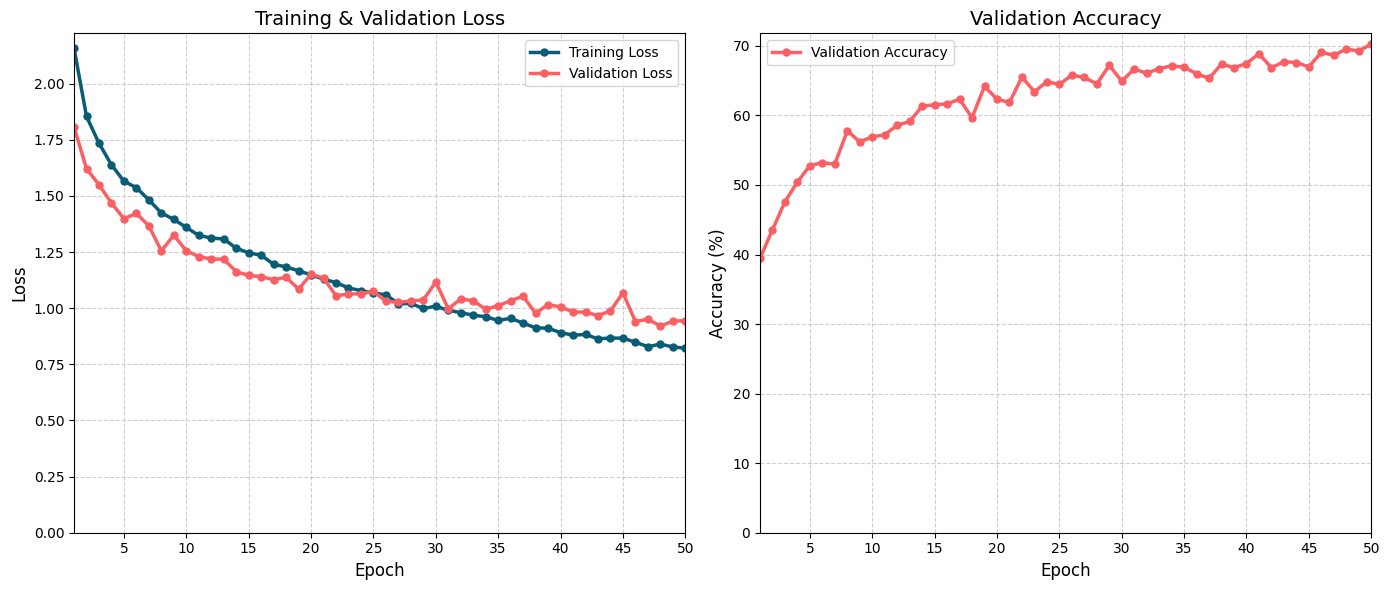

In [36]:
# Start the training process by calling the training loop function
trained_model, training_metrics = training_loop(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    loss_function=loss_function, 
    optimizer=optimizer, 
    num_epochs=50, 
    device=device
)

# Visualize the training metrics (loss and accuracy)
print("\n--- Training Plots ---\n")
helper_utils.plot_training_metrics(training_metrics)